# Synopsis

# Configuration

In [1]:
slug = 'HarryPotter'
db_file = "/sfs/qumulo/qhome/sk5be/DS5559/HarryPotter.db"
# vocab_weight = 'tfidf_sum'
vocab_weight = 'tf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity as KDE

# Pragmas

In [3]:
from IPython.display import display, HTML

In [4]:
%matplotlib inline
%pwd

'/sfs/qumulo/qhome/sk5be/DS5559/lab6'

# Functions

In [5]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

# Process

## Import tables from database

In [6]:
with sqlite3.connect(db_file) as db:
    V = pd.read_sql("SELECT * FROM vocab WHERE stop = 0", db, index_col='term_id')
    K = pd.read_sql("SELECT term_id, term_str FROM token WHERE term_id >= 0", db)

## Prepare Tokens index

We don't have to flatten the index since we just grabbed one column from the table.

In [7]:
K.rename_axis('offset', inplace=True)

In [8]:
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_id,4164,14357,20883,3351,23170,12406,13606,1754,13607,7069,14272
term_str,chapter,one,the,boy,who,lived,mr,and,mrs,dursley,of


## Filter Vocab

In [9]:
V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max,idf
term_id,,,,,,,,,,,,,,,,,,,
0,''just,1,8.912283e-07,''just,0,1,0.000246,0.000001,0.000246,2.298853,0.011552,2.298853,7.236781e-07,3.636573e-09,7.234508e-07,0.002947,0.000015,0.002944,2.298853
1,''professor,1,8.912283e-07,''professor,0,1,0.000332,0.000002,0.000332,2.298853,0.011552,2.298853,1.273337e-06,6.398678e-09,1.273041e-06,0.003837,0.000019,0.003835,2.298853
2,''was,1,8.912283e-07,''wa,0,1,0.000465,0.000002,0.000464,2.298853,0.011552,2.298853,2.390064e-06,1.201037e-08,2.389668e-06,0.005145,0.000026,0.005143,2.298853
3,'a,52,4.634387e-05,'a,0,30,0.015691,0.000079,0.002221,42.730055,0.214724,4.108659,2.613530e-03,1.313332e-05,3.699704e-04,0.166562,0.000837,0.019579,0.821732
4,'aaaaaah,1,8.912283e-07,'aaaaaah,0,1,0.000496,0.000002,0.000496,2.298853,0.011552,2.298853,2.697485e-06,1.355520e-08,2.697066e-06,0.005443,0.000027,0.005440,2.298853


In [10]:
V1 = V[(V[vocab_weight] > V[vocab_weight].quantile(vocab_weight_quantile)) & (V.n >= vocab_min_n)]

In [11]:
V1.shape[0]

1411

In [12]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,10048,17681,874,13771,17460,10282,2340,7027,11921,12494
term_str,harry,said,'s,n't,ron,hermione,back,dumbledore,know,looked
n,18007,14420,11230,6259,6252,5290,3420,3259,2498,2345
p,0.0160483,0.0128515,0.0100085,0.0055782,0.00557196,0.0047146,0.003048,0.00290451,0.00222629,0.00208993
port_stem,harri,said,'s,n't,ron,hermion,back,dumbledor,know,look
stop,0,0,0,0,0,0,0,0,0,0
df,199,198,167,165,180,175,199,176,198,199
tf_sum,6.36283,4.94168,3.86191,2.21485,2.16524,1.79241,1.21693,1.15465,0.872991,0.819756
tf_mean,0.031974,0.0248326,0.0194066,0.0111299,0.0108806,0.0090071,0.00611523,0.00580227,0.00438689,0.00411938
tf_max,0.0569314,0.0494308,0.0445509,0.0284441,0.0340055,0.0296439,0.0143083,0.039502,0.0108073,0.0119271
tfidf_sum,0,31.5493,855.014,509.289,272.466,295.261,0,173.836,5.46534,0


## Get list of top terms

We'll use this later.

In [13]:
TOP_TERMS = V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [14]:
TOP_TERMS

['harry',
 'said',
 "'s",
 "n't",
 'ron',
 'hermione',
 'back',
 'dumbledore',
 'know',
 'looked',
 'around',
 'got',
 'hagrid',
 'see',
 'professor',
 'snape',
 'time',
 'think',
 'looking',
 'wand',
 'eyes',
 'get',
 "'ve",
 'face',
 'weasley',
 'right',
 'going',
 'voice',
 "'re",
 "'ll"]

## Filter Tokens by Vocab

In [15]:
K = K[K.term_id.isin(V1.index)]

In [16]:
K.head(11).T

offset,0,3,5,6,8,9,11,12,13,14,22
term_id,4164,3351,12406,13606,13607,7069,14134,8850,15906,6926,15107
term_str,chapter,boy,lived,mr,mrs,dursley,number,four,privet,drive,perfectly


## Create arrays of offsets for each term

In [17]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [18]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [19]:
B.head()

,offset,x
term_str,,
'and,"[177812, 475607, 479029, 481586, 481686, 48353...","[[177812], [475607], [479029], [481586], [4816..."
'but,"[249302, 409044, 478611, 480728, 481394, 48475...","[[249302], [409044], [478611], [480728], [4813..."
'd,"[34, 880, 898, 1107, 1146, 1390, 1743, 1853, 1...","[[34], [880], [898], [1107], [1146], [1390], [..."
'do,"[476236, 478634, 479371, 479398, 480612, 48655...","[[476236], [478634], [479371], [479398], [4806..."
'em,"[11238, 14508, 14564, 14635, 14663, 14668, 147...","[[11238], [14508], [14564], [14635], [14663], ..."


## Get KDE for each term

In [20]:
scale_max = K.index.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
# B['scaled'] = B.apply(lambda row: np.exp(row.scores) * (scale_max / kde_samples), axis=1)

## Visualize KDE plots

In [21]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

In [22]:
FIG = dict(figsize=(15, 5))

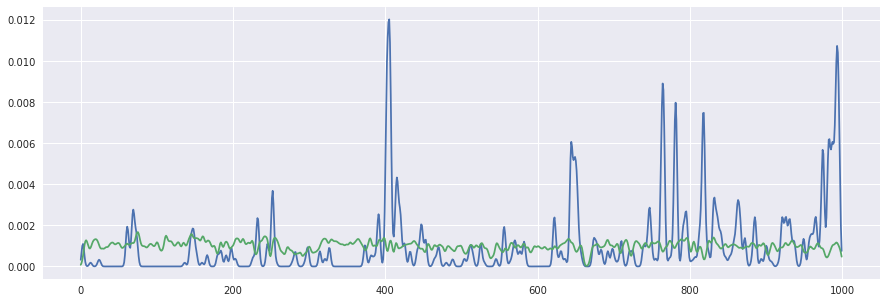

In [23]:
PLOTS.loc['voldemort'].plot(**FIG)
PLOTS.loc['harry'].plot(**FIG)

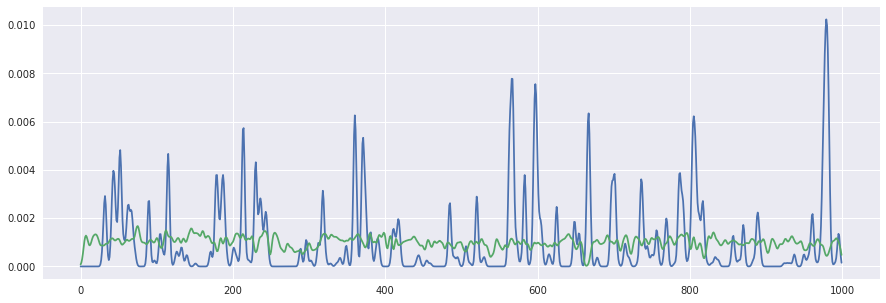

In [24]:
PLOTS.loc['snape'].plot(**FIG)
PLOTS.loc['harry'].plot(**FIG)

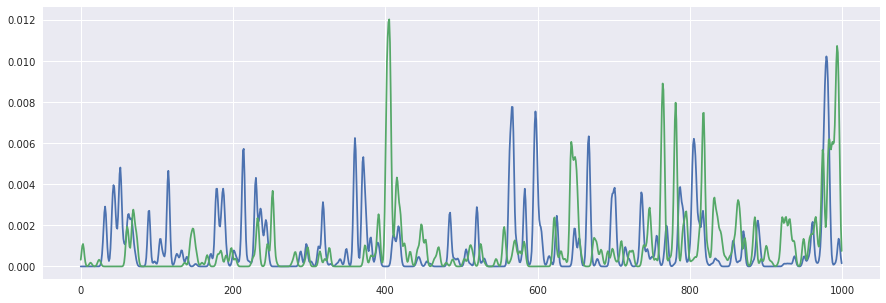

In [25]:
PLOTS.loc['snape'].plot(**FIG)
PLOTS.loc['voldemort'].plot(**FIG)

## Score Pairs

We generate only unique combinations of pairs not permutation, i.e. we treat `a,b == b,a`.

In [26]:
pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])

In [27]:
pairs.head(10).T

,0,1,2,3,4,5,6,7,8,9
x,'and,'and,'and,'and,'and,'and,'and,'and,'and,'and
y,'but,'d,'do,'em,'harry,'he,'how,'i,'it,'ll


## Compute overlap

This takes a while to run.

In [28]:
def overlap(row):
    kde1 = PLOTS.loc[row.x]
    kde2 = PLOTS.loc[row.y]
    overlap = np.minimum(kde1, kde2)
    return np.trapz(overlap)

In [29]:
pairs['overlap'] = pairs.apply(overlap, axis=1)

In [30]:
def paircorr(row):
    return PLOTS.T[[row.x,row.y]].corr().values[0][1]

In [31]:
pairs['corr'] = pairs.apply(paircorr, axis=1)

## Skim Top Pairs

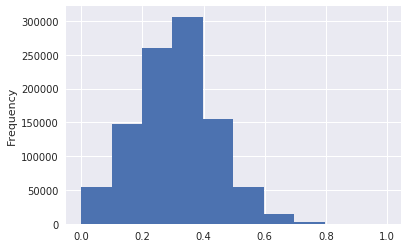

In [32]:
pairs.overlap.plot.hist()

In [33]:
pairs[pairs.overlap > .3 ].sort_values('overlap', ascending=False).head()

,x,y,overlap,corr
311596,coupons,promo,0.994562,1.0
233531,cash,promo,0.994533,1.0
232924,cash,ebatescom,0.994526,1.0
232824,cash,coupons,0.994523,1.0
423446,ebatescom,promo,0.994495,1.0


In [53]:
pairs[pairs.x =="voldemort"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
990848,voldemort,wand,0.485166,0.334149
990851,voldemort,wanted,0.481316,0.244890
990869,voldemort,whether,0.462108,0.151835
990850,voldemort,want,0.456925,0.048468
990872,voldemort,white,0.453081,0.184144
990920,voldemort,years,0.452727,0.173026
990900,voldemort,words,0.442087,0.133167
990874,voldemort,whose,0.431175,0.112100
990925,voldemort,yes,0.427571,0.111514
990871,voldemort,whispered,0.427418,0.052718


In [56]:
pairs[pairs.x =="severus"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
933040,severus,snape,0.444585,0.580960
933241,severus,voldemort,0.318501,0.252823
933065,severus,speak,0.307844,0.304355
933097,severus,stood,0.303629,0.314288
933193,severus,toward,0.301723,0.095854
932982,severus,shall,0.297640,0.251726
932999,severus,shrieked,0.292630,0.239625
933007,severus,silence,0.291853,0.189079
933208,severus,truth,0.290644,0.100567
933302,severus,word,0.285244,0.217888


In [35]:
pairs[pairs.x =="lily"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
744832,lily,severus,0.325207,0.626209
744653,lily,parents,0.275458,0.251427
744572,lily,moved,0.244583,0.256625
744805,lily,scene,0.244099,0.623956
744484,lily,lived,0.237356,0.129002
744569,lily,mother,0.233223,0.083770
744894,lily,snape,0.216158,0.465031
744865,lily,simply,0.210710,0.066251
744483,lily,live,0.208861,0.199556
744857,lily,sideways,0.208152,0.181105


In [36]:
pairs[pairs.x =="james"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
692571,james,lily,0.480419,0.434193
692608,james,lupin,0.308027,0.220670
692748,james,parents,0.302362,0.175076
692515,james,killed,0.270139,0.119680
692998,james,somebody,0.261280,0.230431
692514,james,kill,0.260008,0.100687
692989,james,snape,0.254338,0.366023
692664,james,mother,0.252832,0.078827
692667,james,moved,0.250491,0.131106
692746,james,paper,0.248980,0.434752


In [54]:
pairs[pairs.x =="dumbledore"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
407767,dumbledore,yes,0.589464,0.405070
407601,dumbledore,think,0.587739,0.205956
406904,dumbledore,happened,0.580018,0.272248
407405,dumbledore,seemed,0.579832,0.173132
407146,dumbledore,moment,0.577540,0.259603
407615,dumbledore,time,0.574225,0.082332
407403,dumbledore,see,0.572921,0.070849
407561,dumbledore,sure,0.572699,0.182275
407108,dumbledore,man,0.571320,0.297529
407010,dumbledore,knew,0.570404,0.149480


In [38]:
pairs[pairs.x =="riddle"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
911580,riddle,tom,0.543123,0.619995
911360,riddle,secrets,0.327216,0.442133
911347,riddle,scarlet,0.211921,0.227229
911470,riddle,split,0.205022,0.158632
911638,riddle,voldemort,0.201304,0.062622
911411,riddle,sir,0.201086,0.134838
911393,riddle,show,0.197230,0.198827
911720,riddle,years,0.194195,0.167232
911620,riddle,understood,0.193434,0.183508
911455,riddle,sorting,0.193246,0.230965


In [39]:
pairs[pairs.x =="elder"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
431552,elder,hallows,0.484463,0.659954
431962,elder,promo,0.325853,0.435977
432038,elder,savings,0.322207,0.432703
431611,elder,horcruxes,0.284620,0.216152
432414,elder,xenophilius,0.258626,0.496497
431745,elder,lovegood,0.233148,0.339626
431534,elder,grindelwald,0.227659,0.156944
431871,elder,ollivander,0.209819,0.354081
432346,elder,wand,0.208683,0.534273
432336,elder,voldemort,0.204210,0.286480


In [40]:
pairs[pairs.x =="dobby"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
382630,dobby,elf,0.473889,0.496285
382632,dobby,elves,0.416005,0.557375
383374,dobby,sir,0.406479,0.647312
383646,dobby,winky,0.298486,0.470336
382626,dobby,eight,0.294461,0.271168
383212,dobby,potter,0.252113,0.436213
382614,dobby,ears,0.242623,0.359863
383220,dobby,pretty,0.241336,0.168520
382801,dobby,grinning,0.239137,0.251007
383575,dobby,twenty,0.236320,0.145516


In [41]:
pairs[pairs.x =="bellatrix"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
145907,bellatrix,narcissa,0.492058,0.687773
145815,bellatrix,lord,0.347418,0.494531
145826,bellatrix,lucius,0.346916,0.475566
145431,bellatrix,eaters,0.323358,0.288668
145366,bellatrix,death,0.320042,0.313225
145247,bellatrix,burned,0.313583,0.444135
145594,bellatrix,goblin,0.309097,0.422383
146041,bellatrix,prophecy,0.301057,0.398736
145389,bellatrix,directly,0.285232,0.344487
145615,bellatrix,griphook,0.279454,0.413587


In [42]:
pairs[pairs.x =="quidditch"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
896223,quidditch,team,0.573327,0.686247
896009,quidditch,ron,0.572066,0.264356
896167,quidditch,started,0.569470,0.301015
896017,quidditch,said,0.566547,0.119190
895986,quidditch,really,0.563018,0.238430
896255,quidditch,time,0.549131,0.085112
896401,quidditch,year,0.538711,0.250356
896332,quidditch,want,0.537965,0.112488
896043,quidditch,see,0.536994,0.040754
896261,quidditch,told,0.534395,0.070530


In [43]:
pairs[pairs.x =="gryffindor"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
607696,gryffindor,slytherin,0.605504,0.654582
607550,gryffindor,quidditch,0.581309,0.453133
607595,gryffindor,ron,0.570214,0.312584
607531,gryffindor,professor,0.553039,0.367798
607753,gryffindor,started,0.551564,0.290406
607157,gryffindor,hermione,0.536563,0.125609
607941,gryffindor,whole,0.534945,0.269753
607752,gryffindor,start,0.530913,0.330766
607603,gryffindor,said,0.529941,-0.042560
607304,gryffindor,look,0.528797,0.111140


In [44]:
pairs[pairs.x =="slytherin"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
950204,slytherin,slytherins,0.496858,0.533018
950288,slytherin,suddenly,0.430256,0.184616
950448,slytherin,whole,0.425281,0.251551
950260,slytherin,started,0.417908,0.150655
950224,slytherin,something,0.417218,0.118683
950316,slytherin,team,0.416846,0.440334
950403,slytherin,usual,0.415564,0.225995
950315,slytherin,teachers,0.414488,0.240772
950307,slytherin,taking,0.403635,0.157843
950273,slytherin,straight,0.402428,0.176222


In [45]:
pairs[pairs.x =="umbridge"].sort_values('overlap', ascending=False).head(10)

,x,y,overlap,corr
988746,umbridge,written,0.274191,0.242240
988690,umbridge,watching,0.256833,0.200847
988744,umbridge,write,0.242379,0.132487
988702,umbridge,whether,0.238019,0.143640
988721,umbridge,within,0.237976,0.086644
988708,umbridge,wide,0.231887,0.209955
988652,umbridge,understand,0.227791,0.167292
988669,umbridge,voice,0.227063,0.195523
988661,umbridge,usual,0.224675,0.117617
988725,umbridge,wo,0.219013,0.124176


In [46]:
pairs2 = pairs.copy().rename(columns={'x':'y', 'y':'x'})
pairs3 = pd.concat([pairs, pairs2], sort=True)

## See related terms for top terms

In [69]:
MAIN_TERMS = [ 'lily','severus','james']

In [70]:
DETAIL = '<table>'
for i, term in enumerate(MAIN_TERMS):
    friends = pairs3[pairs3.x == term].sort_values('overlap', ascending=False).head(10)
    DETAIL += "<tr><td colspan=1><b>{}. {}</b></td></tr>".format(i+1, term)
    for row in friends.reset_index(drop=True)[['y', 'overlap']].values:
        bar = round(row[1] * 100) * '|'
        DETAIL += "<tr><td>{}</td><td style='text-align:left;'>{} ({})</td></tr>".format(row[0], bar, row[1])
DETAIL += "</table>"

In [71]:
display(HTML(DETAIL))

## Explore term correlations

In [49]:
CORR = pd.crosstab(pairs3.x, pairs3.y, pairs3.overlap, aggfunc='sum').fillna(1)

In [50]:
CORR.head()

y,'and,'but,'d,'do,'em,'harry,'he,'how,'i,'it,...,yaxley,yeah,year,years,yeh,yelled,yellow,yer,yes,young
x,,,,,,,,,,,,,,,,,,,,,
'and,1.000000,0.769316,0.250492,0.657829,0.153542,0.585931,0.704883,0.682969,0.800330,0.748144,...,0.008730,0.168128,0.245733,0.252689,0.143727,0.185498,0.134723,0.072854,0.170734,0.223957
'but,0.769316,1.000000,0.248996,0.646764,0.154859,0.613351,0.722222,0.711681,0.820362,0.763441,...,0.020278,0.162825,0.244960,0.243417,0.151049,0.190170,0.138067,0.081422,0.168630,0.213333
'd,0.250492,0.248996,1.000000,0.234789,0.320061,0.235870,0.248279,0.235478,0.257638,0.243845,...,0.013607,0.570010,0.550689,0.530682,0.373939,0.420409,0.370943,0.296995,0.541175,0.422779
'do,0.657829,0.646764,0.234789,1.000000,0.127310,0.509170,0.596873,0.600107,0.697047,0.658508,...,0.009121,0.164749,0.236849,0.234280,0.093873,0.176673,0.141787,0.052388,0.161922,0.224007
'em,0.153542,0.154859,0.320061,0.127310,1.000000,0.107257,0.133010,0.142772,0.152476,0.146229,...,0.018650,0.294365,0.196331,0.181180,0.456577,0.223873,0.283476,0.327201,0.207183,0.171488


In [51]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (20,20))
    print(title)
    corr = dtm[terms].corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
    plt.show()

TEST


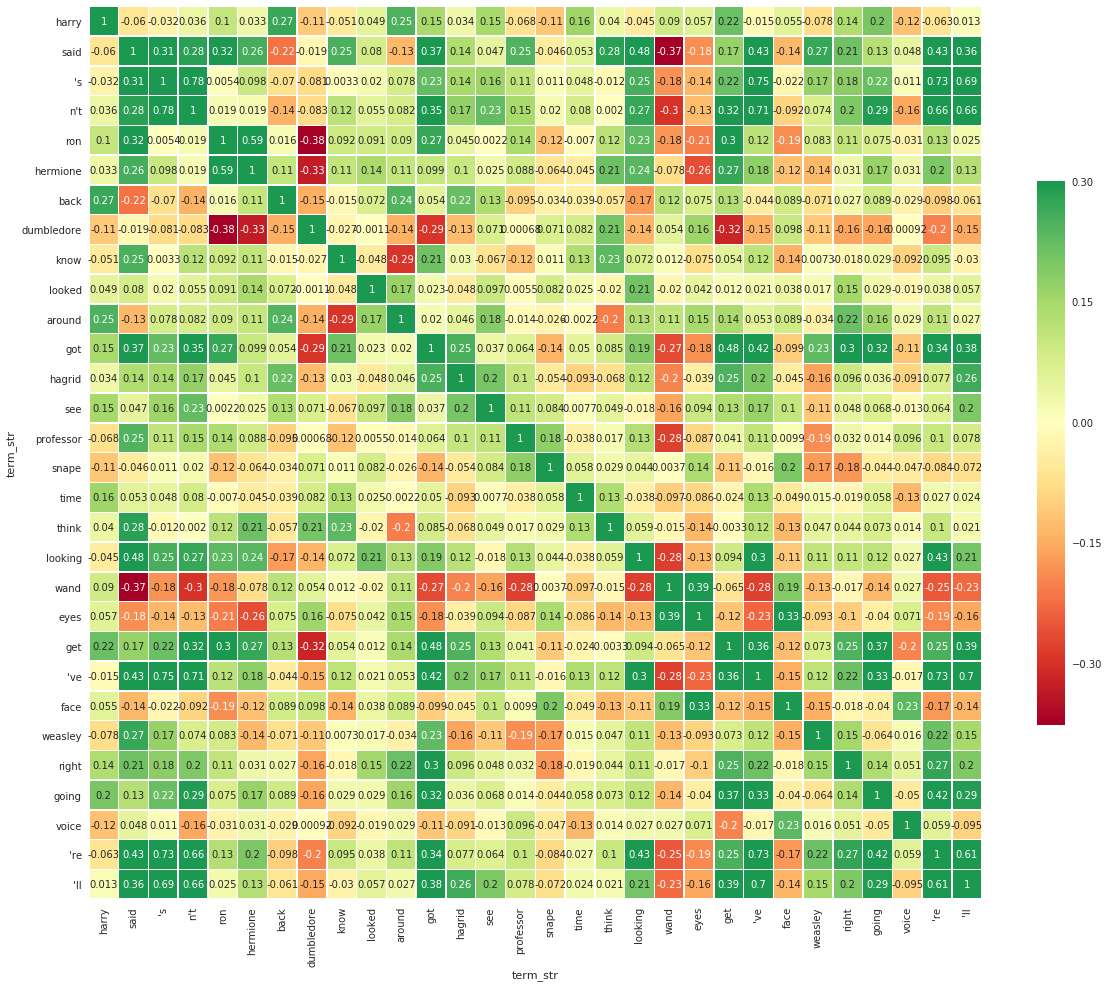

In [52]:
corr_plot_terms(TOP_TERMS, PLOTS.T, title='TEST')

## Export Graphs

In [ ]:
import networkx as nx
G = nx.Graph()
edges = pairs[['x','y','overlap']].sort_values('overlap', ascending=False).head(1000).apply(lambda x: (x.x, x.y, x.overlap), axis=1).values
G.add_weighted_edges_from(edges)
nx.write_gexf(G, "{}.gexf".format(slug))

# Save

In [ ]:
with sqlite3.connect(db_file) as db:
    pairs.to_sql('term_pair', db, if_exists='replace', index=True)
    PLOTS.T.to_sql('term_kde', db, if_exists='replace', index=True)
#     vocab.to_sql('vocab', db, if_exists='replace', index=True)

In [42]:
# END